# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Import Packages
The following libraries are used.  `cv2` is for OpenCV.

Matplotlib is using to showing images.

numpy is for working with numbers.

VideoFileClip is for working with video frames

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os, glob
from moviepy.editor import VideoFileClip
%matplotlib inline

## Reading images
This function is used to read a set of images and showing them in a figure.


In [2]:
def show_images(images, cols, rows, binary = False):
    toShow = []
    for img in images :
        if binary :
            toShow.append(img)
        else :
            toShow.append(cv2.cvtColor(img,  cv2.COLOR_BGR2RGB))
    plt.figure(figsize=(cols * 5 , rows * 2.5))
    for i in range(0, len(toShow)):
        plt.subplot(rows, cols, i+1)
        plt.imshow(toShow[i], cmap="gray")
    plt.show()


now if you want to test `show_images` function you should use it like this : 

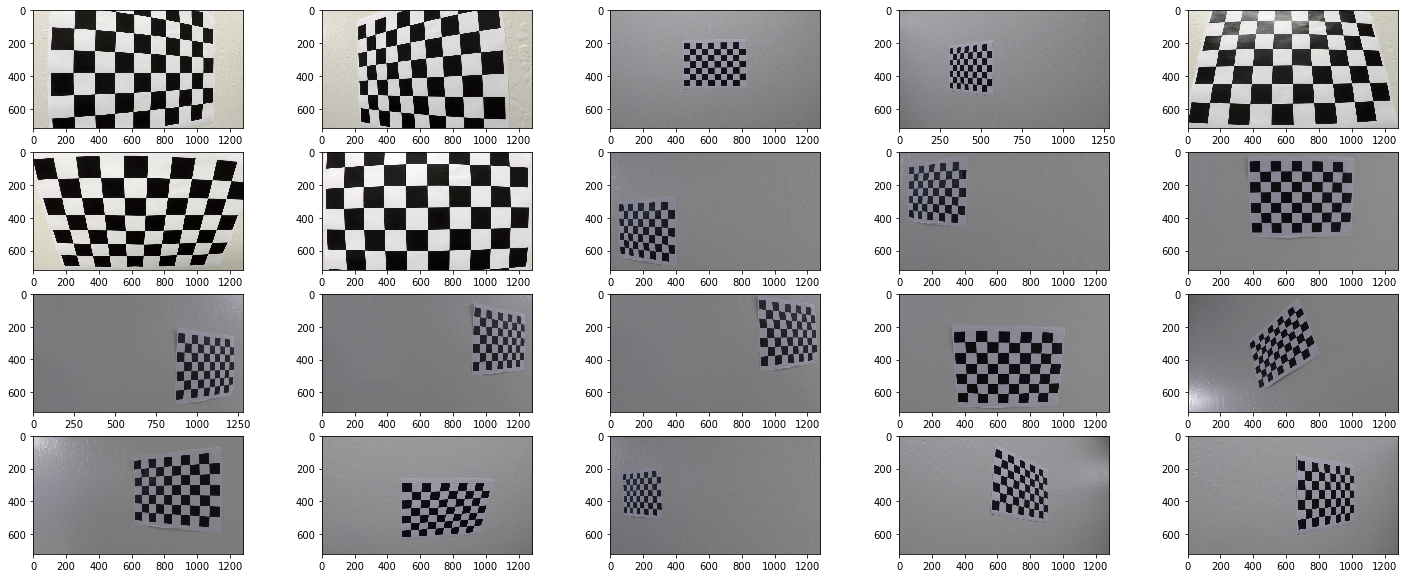

In [3]:
cal_test_images = []
cal_test_images = [cv2.imread(path) for path in glob.glob('camera_cal/*.jpg')]

show_images(cal_test_images, 5, 4)

### Callabaration Camera 

At first we compute camera callibration
in this code for every image we find chessboard corners for every image using `cv2.findChessboardCorners` and then callabrate camera using `cv2.calibrateCamera` function.



In [4]:

def callabration(images_path):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    imageCorners = [] # to show image corners
    

    # Make a list of calibration images
    images = glob.glob(images_path +'/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            imageCorners.append(img)
#             cv2.imshow('img',img)
#             cv2.waitKey(500)
    
    cv2.destroyAllWindows()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return imageCorners, ret, mtx, dist, rvecs, tvecs


After callabration we can see chessboard points


this function doesnt recognize 3 of images.


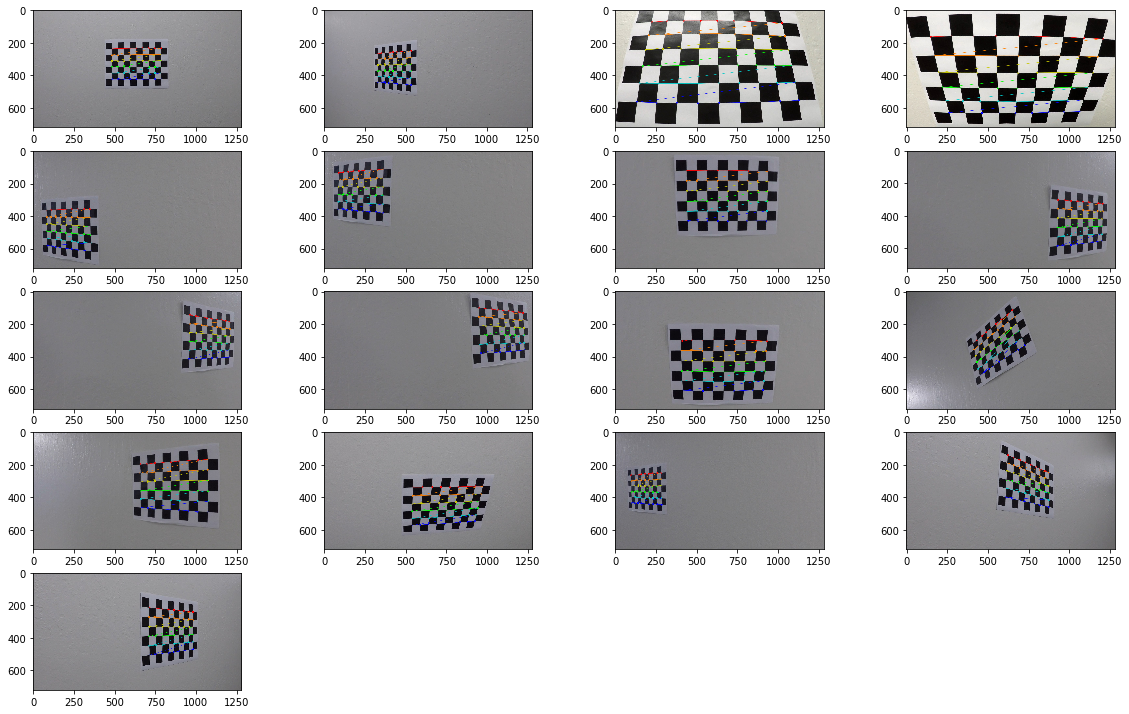

In [5]:
imageCorners, ret, mtx, dist, rvecs, tvecs = callabration("./camera_cal")
show_images(imageCorners, 4, 5)

### Distortion Correction
after callabration of camera we can get an undistorted image using `cv2.undistort` function.


In [6]:
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, newCameraMatrix=mtx)

and if we undistort images using this function we have : 

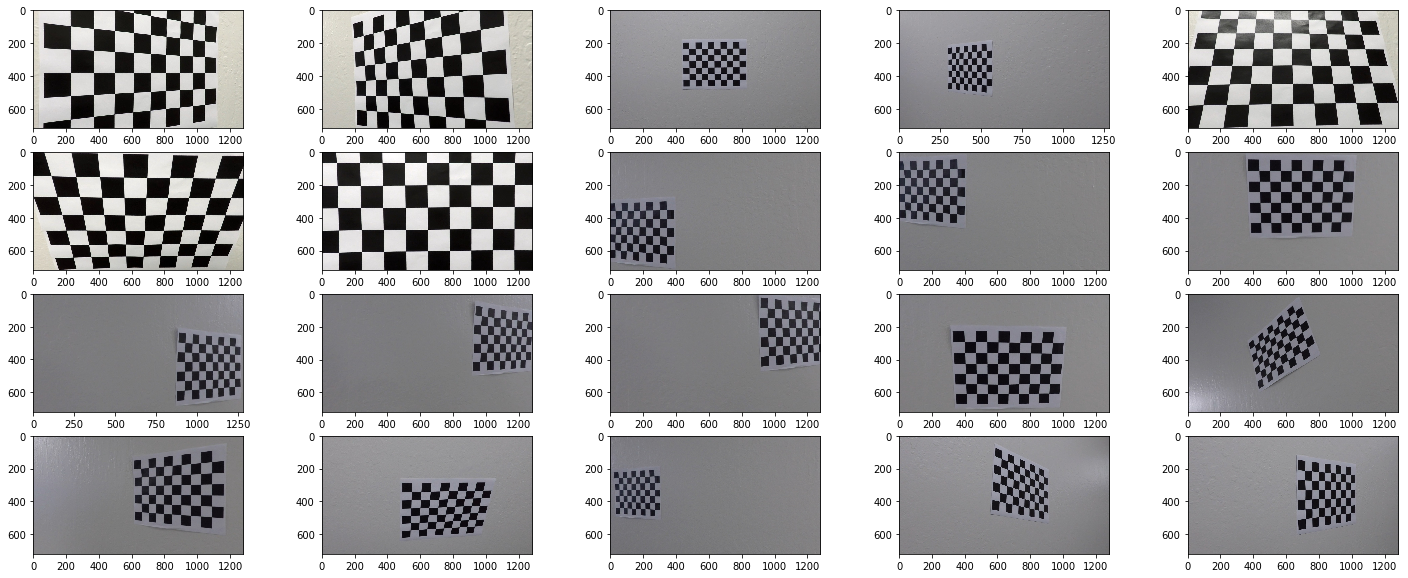

In [7]:
cal_test_images_undistorted = []
for img in cal_test_images :
    cal_test_images_undistorted.append(undistort(img, mtx, dist))
show_images(cal_test_images_undistorted, 5, 4)

and if we use this functions on road images we have : 

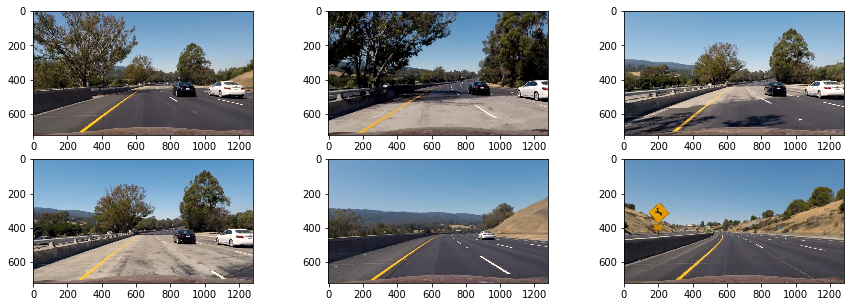

In [8]:
undistorted_test_images = []
test_images = [cv2.imread(path) for path in glob.glob('test_images/*.jpg')]
for img in test_images :
    undistorted_test_images.append(undistort(img, mtx, dist))
show_images(undistorted_test_images, 3, 2)

### Perspective Transform
for seeing road from up we use `wrapPrespective` in region of interest of image.

we can find best region of interest with with playing with numbers

in `getPrespectiveTransform`
* src is Coordinates of quadrangle vertices in the source image.
* dst is Coordinates of the corresponding quadrangle vertices in the destination image.


In [9]:
def prespective(img):
    rows, cols = img.shape[:2]
    bottom_left  = [cols*0.1, rows*0.98]
    top_left     = [cols*0.43,rows*0.64]
    bottom_right = [cols*0.97,rows*0.98]
    top_right    = [cols*0.585,rows*0.64] 
    src = np.float32([bottom_right,    
                      bottom_left,    
                      top_left,   
                      top_right])  
    dst = np.float32([[cols, rows],       
                      [0, rows],       
                      [0, 0],       
                      [cols, 0]])      

    transform = cv2.getPerspectiveTransform(src, dst)
    invTransform = cv2.getPerspectiveTransform(dst, src)

    return transform, invTransform, cv2.warpPerspective(img, transform, (cols, rows), flags=cv2.INTER_LINEAR)


and after that if we use this function on our test_images we have : 


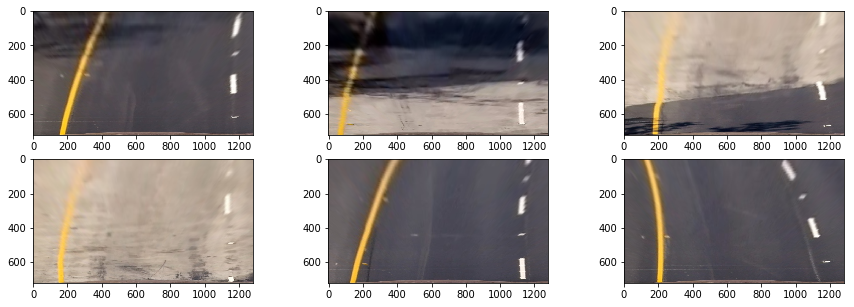

In [10]:
prespective_images = []
T = []
IT = []
for img in undistorted_test_images:
    t, it, out = prespective(img)
    prespective_images.append(out)
    T.append(t)
    IT.append(it)
show_images(prespective_images, 3, 2, False)

### HSV (hue, saturation, value) And Color Selecting
This transform made to more closely align with the way human vision perceives color-making attributes.



**First** we use a function named `img_HSV` that get an image, max threshold and min threshold and then returns masked images

In [11]:
def img_HSV(img, min_values, max_values):
    newI = img
    HSV = cv2.cvtColor(newI, cv2.COLOR_BGR2HSV)

    min_th_ok = np.all(HSV > min_values, axis=2)
    max_th_ok = np.all(HSV < max_values, axis=2)

    out = np.logical_and(min_th_ok, max_th_ok)
    
    return out

#### Selecting Yellow Lines
To select yellow lines we use HSV coloring. range of yellow coloring according to the last phase of project is 0-50, 70-255, 70-255.

I wrote a function named `yellow_HSV` to select yellow colors from our image


In [12]:
def yellow_HSV(img):
    # selected threshold to highlight yellow lines
    yellow_HSV_th_min = np.array([0, 70, 70])
    yellow_HSV_th_max = np.array([50, 255, 255])
    return img_HSV(img, yellow_HSV_th_min, yellow_HSV_th_max)

#### Selecting White Lines
To select white lines we don't use HSV coloring. because it can be handled easily in RGB coloring. according to the last phase of project range of white coloring in RGB is 200-255, 200-255, 200-255.

I wrote a function named `white_mask` which is a mask that mask white colors.


In [13]:
def white_mask(img):
    # selected threshold to highlight yellow lines
    min_w = np.array([190, 190, 190])
    max_w = np.array([255, 255, 255])
    min_th_ok = np.all(img > min_w, axis=2)
    max_th_ok = np.all(img < max_w, axis=2)
    out = np.logical_and(min_th_ok, max_th_ok) 
    return out

#### Selecting Yellow And White Colors

with two last functions we can select all yellow and white colors from image. We just need these two colors in our images and others are unnecessary.

`filter_colors` uses these two functions and do that.

In [14]:
def filter_colors(img):
    h, w = img.shape[:2]

    binary = np.zeros(shape=(h, w), dtype=np.uint8)

    # highlight yellow lines by threshold in HSV color space
    HSV_yellow_mask = yellow_HSV(img)
    binary = np.logical_or(binary, HSV_yellow_mask)

#     highlight white lines by thresholding the equalized frame
    white_mask_out = white_mask(img)
    binary = np.logical_or(binary, white_mask_out)
    
    return binary
    

now if we use this function on our images we can see this : 


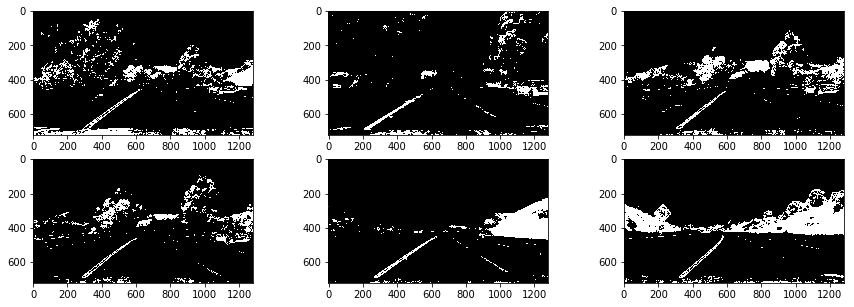

In [15]:
lane_images = list(map(filter_colors, test_images))
show_images(lane_images, 3, 2, binary = True)

### Sobel Transform
Sobel transform helps us to delete unnecessary images. 

we can get this transform in both x and y. after these two transform we should combine them into one image (with `sqrt(G_x ^2 + G_y^2)` formula) . and then change them to binary because we want to combine it with other last transforms.

I think 9 ksize is good.



In [16]:
def sobel_mask(img):
    # converting to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # calculate sobels
    G_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    G_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    # combine two x and y sobels
    sobel = np.sqrt(G_x ** 2 + G_y ** 2)
    # make our sobel result binary
    sobel_binary = np.uint8(sobel / np.max(sobel) * 255)
    _, sobel_binary = cv2.threshold(sobel_binary, 50, 1, cv2.THRESH_BINARY)
    
    return sobel, sobel_binary

So if we show sobel images we have these images :

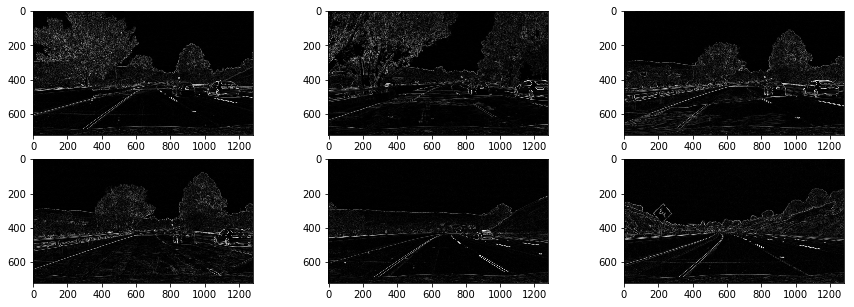

In [17]:
sobel_images = []
for img in test_images :
    sobel, sobel_binary = sobel_mask(img)
    sobel_images.append(sobel)
show_images(sobel_images, 3, 2, binary = True)

**Now** we combine this filter to last of our color filter and then we can process images just with `filter_colors`.

 At the end of this function we use morphology closure to fill the gaps of binary image and have a smoother image.
 


In [18]:
def filter_colors(img):
    h, w = img.shape[:2]

    binary = np.zeros(shape=(h, w), dtype=np.uint8)

    # highlight yellow lines by threshold in HSV color space
    HSV_yellow_mask = yellow_HSV(img)
    binary = np.logical_or(binary, HSV_yellow_mask)
    # highlight white lines by thresholding the equalized frame
    white_mask_out = white_mask(img)
    binary = np.logical_or(binary, white_mask_out)
    # highlight edges using sobel transform
    _, sobel_binary = sobel_mask(img)
    binarya = np.logical_or(binary, sobel_binary)
    
    
    # apply a light morphology to "fill the gaps" in the binary image
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(binary.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    return closing

And if we filter images with this filter we see this : 

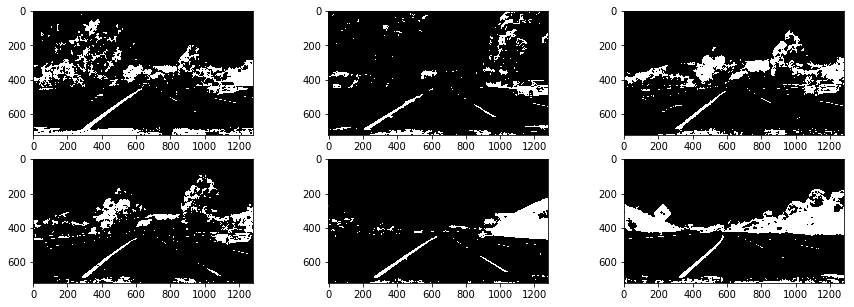

In [19]:
lane_images = list(map(filter_colors, test_images))
show_images(lane_images, 3, 2, binary = True)

**And** now we can use this images before seting prespective 

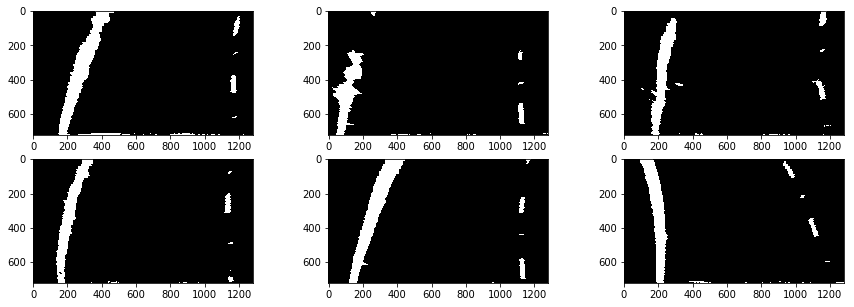

In [20]:
undistorted_b_test_images = []
for img in lane_images :
    undistorted_b_test_images.append(undistort(img, mtx, dist))
prespective_images = []
T = []
IT = []
for img in undistorted_b_test_images:
    t, it, out = prespective(img)
    prespective_images.append(out)
    T.append(t)
    IT.append(it)
show_images(prespective_images, 3, 2, True)


### Detecting Lines

#### Histogram 
For detecting lines we first get a sum in one line of our image 

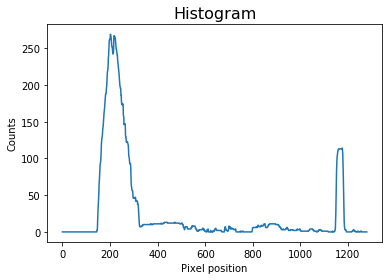

In [21]:
def get_histogram(img):
    return np.sum(img[img.shape[0]//2:, :], axis=0)
    

# Run de function over the combined warped image
histogram = get_histogram(prespective_images[0])

# Plot the results
plt.title('Histogram', fontsize=16)
plt.xlabel('Pixel position')
plt.ylabel('Counts')
plt.plot(histogram)

If we show histogram of this sum for our first image we recognize that at two region of our image we have more pixels. 

These pixels are our lines and we should select them


#### Selecting lines
For selecting these lines from image we should slice height of image to multiple windows. Then for every row of windows in line positions (margin) if there was more than our threshold pixel (according to last histogram we asuume that it is 50 pixels) we select that window as a line window.

after selecting a window next window margin get update to mean of last windows pixels. and also new point appended to our line.

These functionalities repeated for number of windows and then we have two selected lines.

In [22]:
def detect_lines(img):
    # Take a histogram of the bottom half of the image
    histogram = get_histogram(img)

  
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])   
    nonzeroy = np.array(nonzero[0])
   

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
       
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
         
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Draw left and right lines
    for index in range(img.shape[0]):
        cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
        cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
        

    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img.astype(int)

Now if we run this function on our last filtered images we can detect lines and showing them.

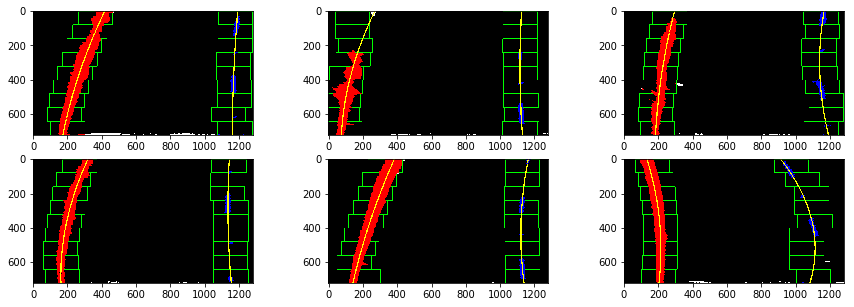

In [23]:
detected_images = []
lines_fit = []
left_points = []
right_points = []


for img in prespective_images :
    lf, lp, rp, out_img = detect_lines(img)
    lines_fit.append(lf)
    left_points.append(lp)
    right_points.append(rp)
    detected_images.append(out_img)
show_images(detected_images, 3, 2, binary = True)

### Drawing Lines 
After detecting lines we should draw them on first undistorted images.

for drawing first i wrote a function that draw a green polygan between two left and right lines. This function is like this


In [24]:
def fill_polygan(color_warp, left_points, right_points):
    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    return color_warp

Then i wrote a function that draw a custom color line with 50 px width. this function is 

In [25]:
def fill_line(color_warp, points, color):
    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = points[0] - 25
    right_fitx = points[0] + 25
    ploty = points[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), color)
    return color_warp

At last we use these three functions to draw lane. 

draw lane function after drawing lines on images make an inverse prespective transform and original picture made from that transform

In [34]:
def draw_lane(img, warped_img, left_points, right_points, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ## Green Polygan
    color_warp = fill_polygan(color_warp, left_points, right_points)
    
    ## left line
    color_warp = fill_line(color_warp, left_points, (0, 0, 255))
    
    ## right line
    color_warp = fill_line(color_warp, right_points, (255, 0, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

# Run the function
img_lane = draw_lane(undistorted_test_images[0], prespective_images[0], left_points[0], right_points[0], IT[0])

So if we call this function on our images we have something like this

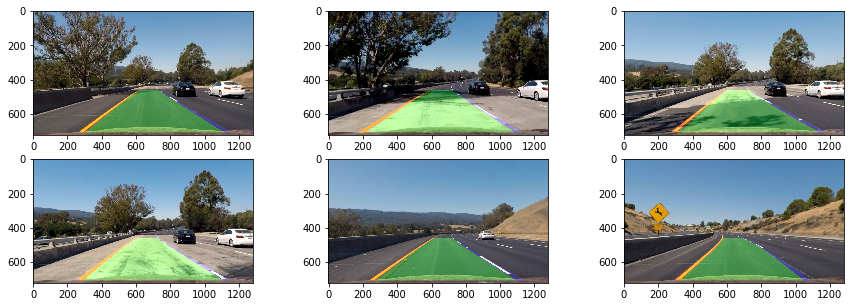

In [27]:
road_images = []
for i in range(0, len(prespective_images)):
    road_images.append(draw_lane(undistorted_test_images[i], prespective_images[i], left_points[i], right_points[i], IT[i]))
show_images(road_images, 3, 2)

## PipeLine
After all our pipe line could be something like this : 


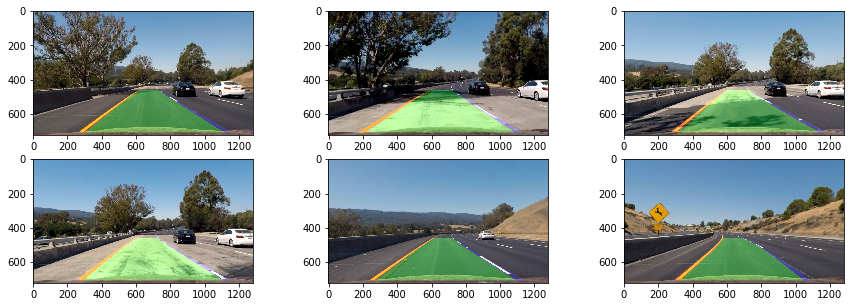

In [28]:
def process_image(image):
    filtered_img = filter_colors(image)
    undistorted_img = undistort(filtered_img, mtx, dist)
    transform, inverseTransform, prespective_img = prespective(undistorted_img)
    lf, lp, rp, out_img = detect_lines(prespective_img)
    undistorted_img_for_lane = undistort(image, mtx, dist)
    result = draw_lane(undistorted_img_for_lane, prespective_img, lp, rp, inverseTransform)
    return result



lane_images = []
test_images = [cv2.imread(path) for path in glob.glob('test_images/*.jpg')]
for img in test_images :
    lane_images.append(process_image(img))
show_images(lane_images, 3, 2)

# Video Lane Finding 

For detecting lanes in video we use our pipeline as `process_image` for every frame of video and make a `process_frame` function to process each frame of video. 


In [29]:
def process_frame(frame):
    try :
        BGR_img = cv2.cvtColor(frame,  cv2.COLOR_RGB2BGR)
        BGR_img = process_image(BGR_img)
        return cv2.cvtColor(BGR_img,  cv2.COLOR_BGR2RGB)
    except Exception as error:
        return frame
    

def process_video(video_input, video_output):
    white_output = 'test_videos_output/' + video_output
    clip1 = VideoFileClip("test_videos/" + video_input)
    white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(white_output, audio=False)

In [30]:
process_video('project_video.mp4', 'project_video.mp4') 
process_video('challenge_video.mp4', 'challenge_video.mp4') 
process_video('harder_challenge_video.mp4', 'harder_challenge_video.mp4') 

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [05:11<00:00,  4.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 5min 1s, sys: 48.1 s, total: 5min 49s
Wall time: 5min 12s
[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4


100%|██████████| 485/485 [01:53<00:00,  2.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

CPU times: user 1min 51s, sys: 16.3 s, total: 2min 7s
Wall time: 1min 54s
[MoviePy] >>>> Building video test_videos_output/harder_challenge_video.mp4
[MoviePy] Writing video test_videos_output/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [05:13<00:00,  3.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/harder_challenge_video.mp4 

CPU times: user 4min 59s, sys: 46 s, total: 5min 45s
Wall time: 5min 15s


In [31]:
from IPython.display import HTML
HTML("""
<table>
    <tr>
        <td> <video width="320" height="240" controls> <source src="{0}"> </video> </td>
        <td> <video width="320" height="240" controls> <source src="{1}"> </video> </td>
        <td> <video width="320" height="240" controls> <source src="{2}"> </video> </td>
    <tr>
    
</table>

""".format("test_videos_output/project_video.mp4", "test_videos_output/challenge_video.mp4", "test_videos_output/harder_challenge_video.mp4"))